## Постановка задачи

Задача — провести анализ клиентских анкет и подготовить план действий по удержанию клиентов для сети фитнес-центров «Культурист-датасаентист».

А именно:

    - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    - проанализировать основные признаки, наиболее сильно влияющие на отток;
    - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.
        
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет.

### Описание данных

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля: 

Данные клиента за предыдущий до проверки факта оттока месяц:

    'gender' — пол;
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    'Phone' — наличие контактного телефона;
    'Age' — возраст;
    'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

    'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    'Group_visits' — факт посещения групповых занятий;
    'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
    'Churn' — факт оттока в текущем месяце.

## Чтение данных

Импортируем нужные библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score

import itertools

pd.options.display.float_format = '{:,.2f}'.format # форматирует все длинные значения в проекте

Прочитаем данные и загрузим их в переменную data. Посмотрим на первые 5 строк датасета и информацию о нем.

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В датасете 4000 записей и 14 столбцов. Пропусков в данных нет. Типы данных в датасете корректные. Изменим заголовки столбцов - запишем их маленькими буквами.

In [5]:
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Проверим датасет на дубликаты.

In [6]:
data.duplicated().sum()

0

Дубликатов не обнаружено. Проверим, нет ли аномальных значений.

In [21]:
data.apply(lambda x: x.unique())

gender                                                                          [1, 0]
near_location                                                                   [1, 0]
partner                                                                         [1, 0]
promo_friends                                                                   [1, 0]
phone                                                                           [0, 1]
contract_period                                                             [6, 12, 1]
group_visits                                                                    [1, 0]
age                                  [29, 31, 28, 33, 26, 34, 32, 30, 23, 27, 35, 2...
avg_additional_charges_total         [14.227470422861144, 113.2029376510582, 129.44...
month_to_end_contract                [5.0, 12.0, 1.0, 6.0, 3.0, 10.0, 11.0, 9.0, 4....
lifetime                             [3, 7, 2, 0, 1, 11, 4, 8, 14, 6, 5, 15, 12, 21...
avg_class_frequency_total            [0.020

In [14]:
data['age'].unique()

array([29, 31, 28, 33, 26, 34, 32, 30, 23, 27, 35, 25, 36, 24, 21, 37, 22,
       19, 20, 38, 39, 18, 41])

In [15]:
data['month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

In [16]:
data['lifetime'].unique()

array([ 3,  7,  2,  0,  1, 11,  4,  8, 14,  6,  5, 15, 12, 21, 10, 20,  9,
       13, 17, 16, 24, 22, 31, 26, 23, 18, 19, 27, 29])

In [18]:
data.query('avg_additional_charges_total<0')['avg_additional_charges_total'].count()

0

In [19]:
data.query('avg_class_frequency_total<0')['avg_class_frequency_total'].count()

0

In [20]:
data.query('avg_class_frequency_current_month<0')['avg_class_frequency_current_month'].count()

0

### Выводы

Данные проверены на пропуски, дубликаты и аномалии и подготовлены к дальнейшему анализу. 

##  Исследовательский анализ данных (EDA)

    В нашем датасете 4000 записей, это достаточный для анализа объем. 
    Все категориальные признаки уже преобразованы в числовые.
    Целевая переменная не имеет временную структуру.
    Пропусков в датасете нет.
    
Проверим, есть ли в датасете аномалии. Для этого изучим средние значения и стандартные отклонения признаков.

In [22]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Cтатистические значения без резких отклонений, аномалий в них нет.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [23]:
data_churn1 = data.query('churn == 1').drop('churn', axis=1)
data_churn1.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,"1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00","1,061.00"
mean,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04
std,0.50,0.42,0.48,0.39,0.30,2.13,0.44,2.90,77.70,1.96,1.11,0.69,0.77
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,25.00,50.63,1.00,0.00,1.01,0.42
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,103.81,1.00,1.00,1.49,0.98
75%,1.00,1.00,1.00,0.00,1.00,1.00,1.00,29.00,165.62,1.00,1.00,1.96,1.59
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,38.00,425.54,12.00,9.00,3.48,3.54


In [24]:
data_churn0 = data.query('churn == 0').drop('churn', axis=1)
data_churn0.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,"2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00","2,939.00"
mean,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
std,0.50,0.33,0.50,0.48,0.30,4.72,0.50,3.01,99.80,4.36,3.87,1.02,1.02
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,19.00,0.17,1.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,28.00,76.92,1.00,2.00,1.28,1.30
50%,1.00,1.00,1.00,0.00,1.00,6.00,0.00,30.00,149.88,6.00,4.00,2.04,2.05
75%,1.00,1.00,1.00,1.00,1.00,12.00,1.00,32.00,224.45,10.00,6.00,2.73,2.74
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15


Ушедших в отток клиентов почти в 3 раза меньше, чем тех, кто остался.

Распределение по полу и факту наличия номера телефона тех, кто ушел и не ушел в отток, не отличается.

Проживающих поблизости, пришедших от партнеров и по акции "приведи друга" клиентов больше среди тех, кто не ушел в отток.

Длительность абонемента, факт посещения групповых занятий, возраст, суммарная выручка от других услуг фитнес-центра, количество месяцев до окончания текущего действующего абонемента, средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц выше среди тех, кто не ушел в отток. 

Оценим распределения признаков. Для этого построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

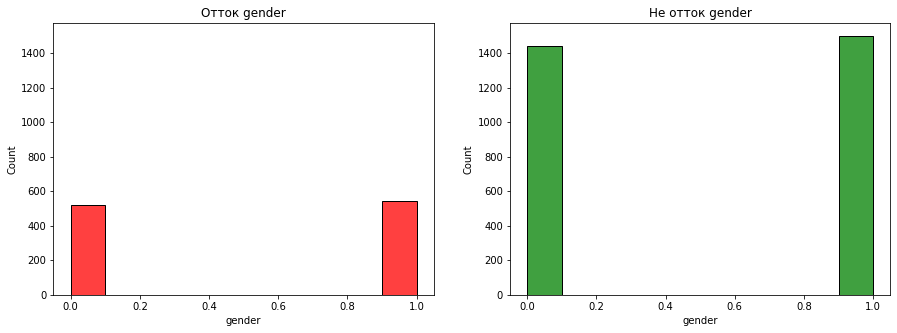

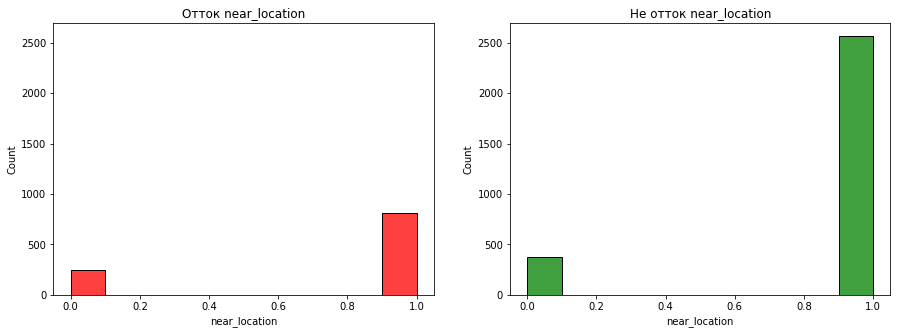

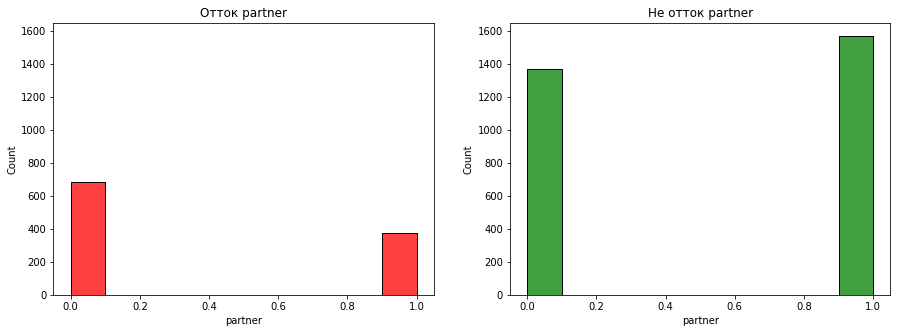

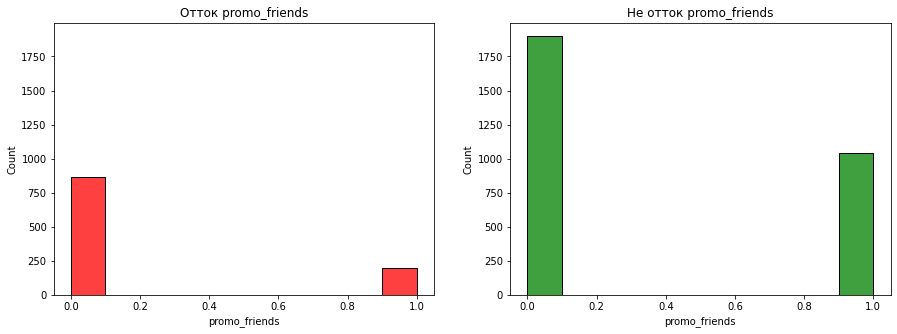

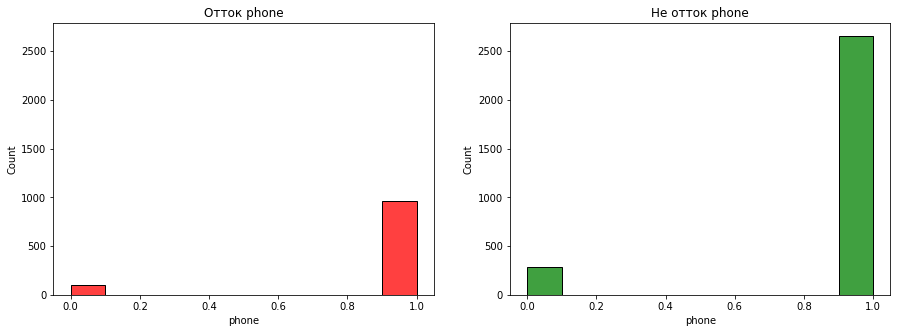

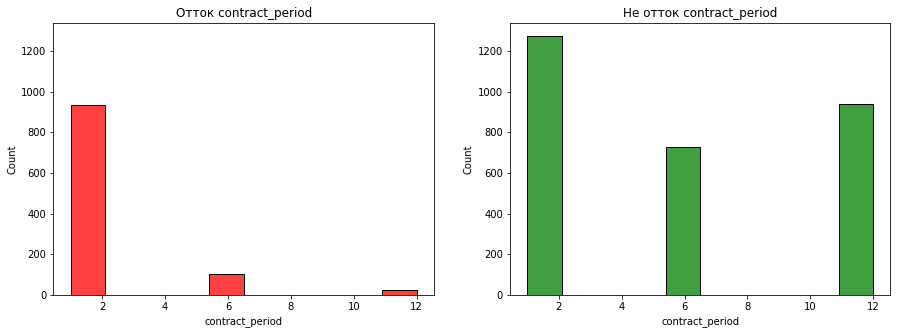

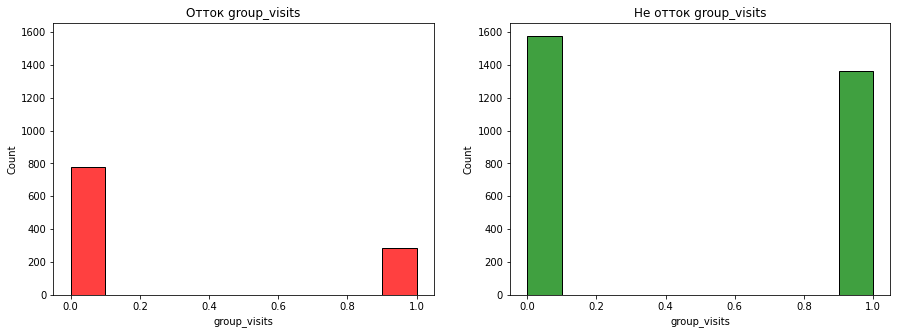

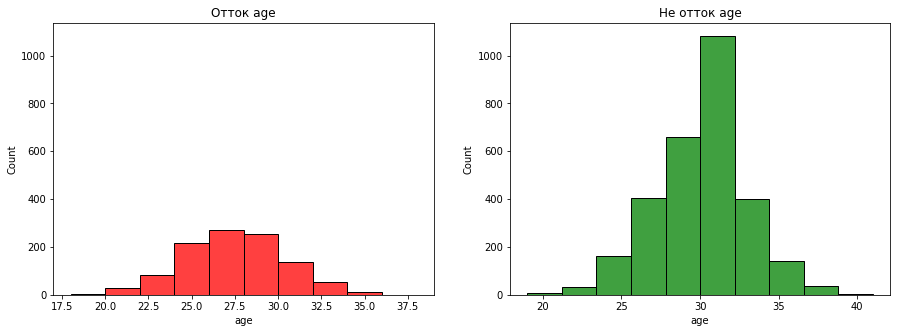

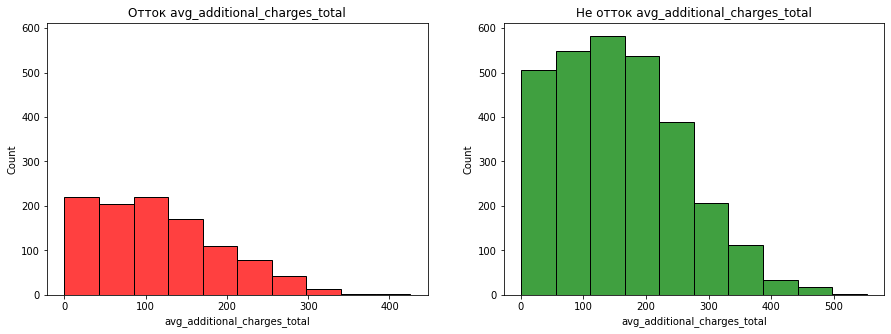

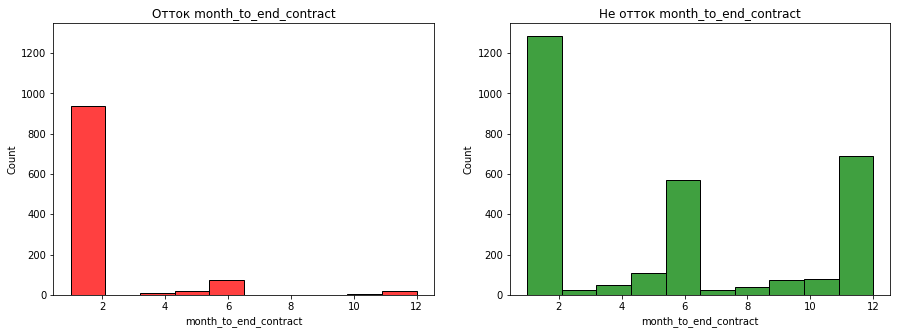

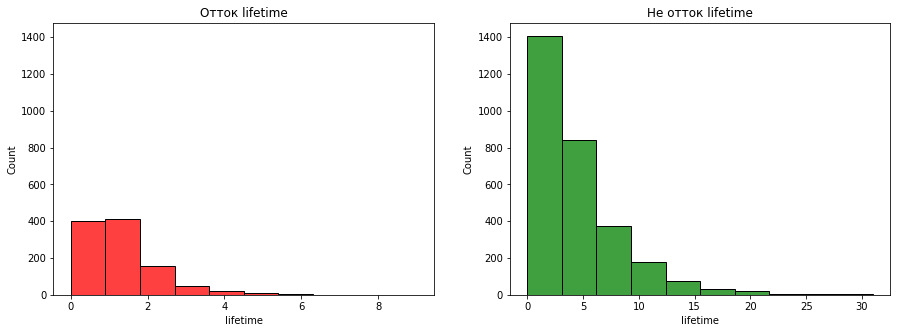

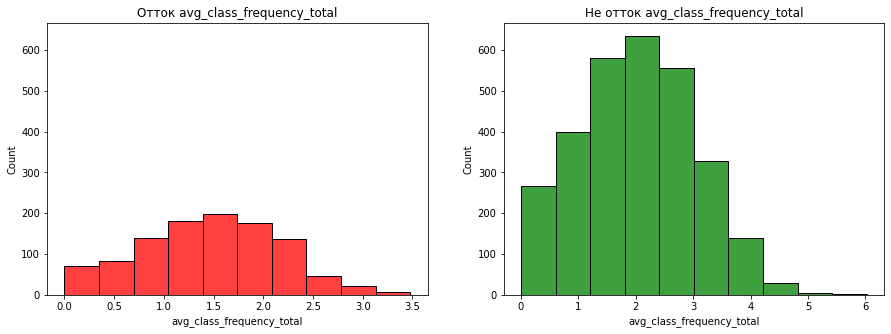

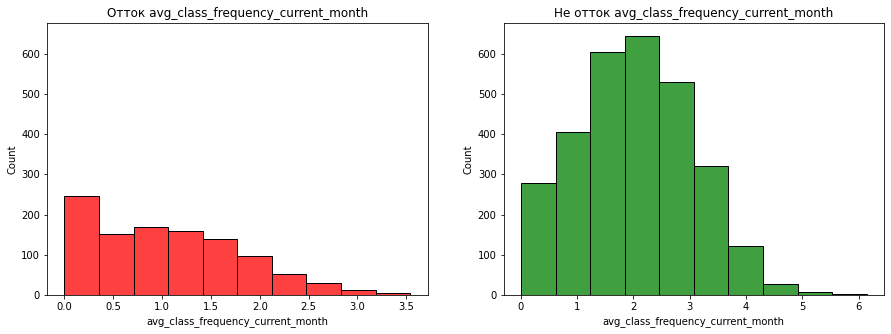

In [27]:
for feature in data_churn1.columns:
            
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))
    
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(data_churn1[feature], bins=10, color='Red', ax=ax1)
    plt.title('Отток {}'. format(feature))

    ax2 = plt.subplot(1, 2, 2, sharey = ax1)
    sns.histplot(data_churn0[feature], bins=10, color='Green', ax=ax2)
    plt.title('Не отток {}'.format(feature))

    plt.show()

На то, что клиент остался в клубе, мало повлиял пол, то, что клиент пришел из компании-партнера, посещает групповые занятия. Больше осталось тех, кто живет поблизости, пришел не по акции "приведи друга", оставил номер телефона. 

Длительность абонемента и количество месяцев до его окончания у тех, кто остался, разная - от 1 месяца до 12, хотя больше абонементов на 1 месяц, и до окончания договора так же у большинства 1 месяц.

Распределение по возрасту близко к нормальному. По сумме других услуг клуба распределение также скошено, но это объясняется тем, что часть клиентов не покупает дополнительные услуги.

Распределение количества месяцев с первого посещения клуба скошено, видимо, в клубе много новых клиентов. Распределение средней частоты посещений в неделю за все время с начала действия абонемента и за предыдущий месяц близко к нормальному.

Для оценки корреляции признаков между собой и целевой переменной построим матрицу корреляций и отобразим её в виде хитмэпа.

In [28]:
cm = data.corr()

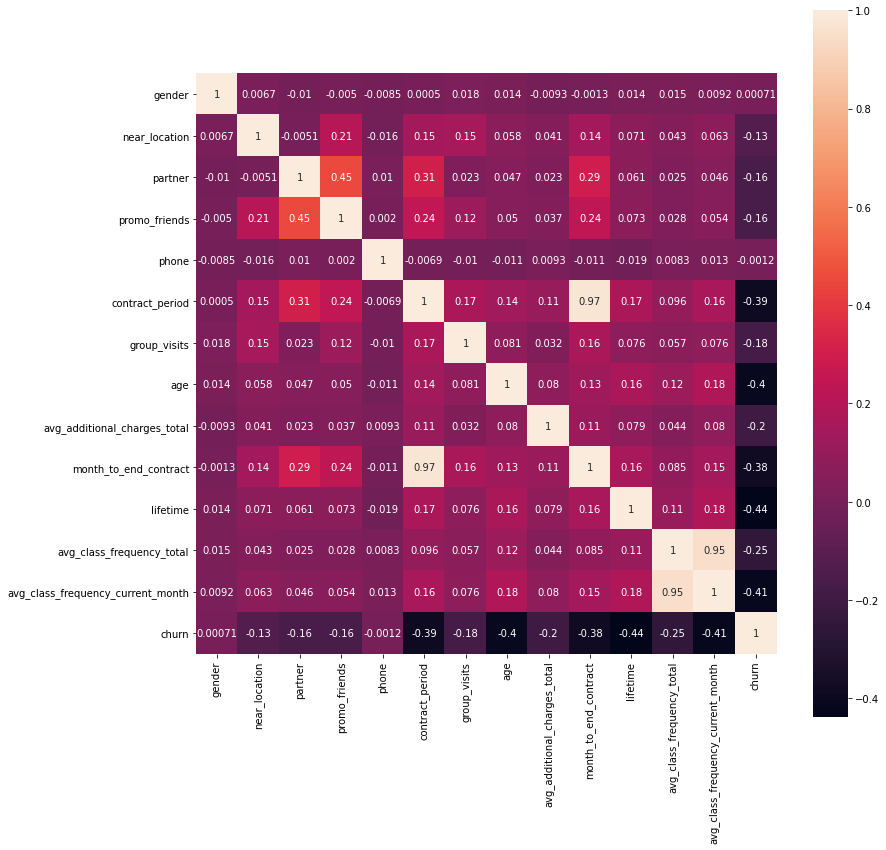

In [29]:
plt.figure(figsize=(13, 13))  
ax = sns.heatmap(cm, annot=True, square=True)
plt.show()

Судя по матрице корреляций, в основном признаки скоррелированны с целевой переменной без высоких значений.
Корреляция с полом и наличием номера телефона незначительная (0.00071 и 0.0012). Средняя корреляция (от 0.13 до 0.25) у признаков "живет поблизости", "пришел по акции", "пришел из компании-партнера", "посещает групповые занятия", "сумма по другим услугам клуба", "частота посещений в неделю за все время с начала действия абонемента". Хорошая корреляция (от 0.39 до 0.44) у признаков "период контракта", "возраст", "количество месяцев до окончания контракта", "частота посещений в неделю за предыдущий месяц", "количества месяцев с первого посещения клуба". 

Между собой признаки скоррелированы не сильно, за исключением пары "период контракта" и "количество месяцев до окончания контракта" (тут понятная прямая зависимость) и пары "средняя частота посещений в неделю" и "средняя частота посещений за предыдущий месяц" (видимо, более активные клиенты активны постоянно). 

Для дополнительного анализа построим графики взаимосвязей этих признаков.

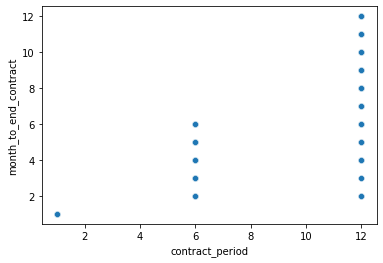

In [30]:
sns.scatterplot(x=data['contract_period'], y=data['month_to_end_contract'])
plt.show()

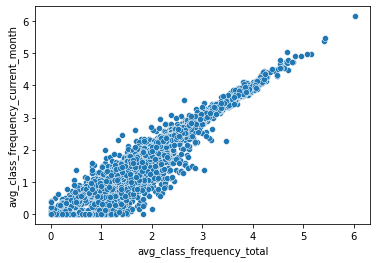

In [31]:
sns.scatterplot(x=data['avg_class_frequency_total'], y=data['avg_class_frequency_current_month'])
plt.show()

Дополнительные графики подтверждают высокую корреляцию пар признаков "период контракта" и "количество месяцев до окончания контракта" и "средняя частота посещений в неделю" и "средняя частота посещений за предыдущий месяц". Это нужно учесть при выборе линейных моделей обучения.

### Выводы

По качеству датасета:

    1. В нашем датасете 4000 записей, это достаточный для анализа объем. 
    2. Все категориальные признаки уже преобразованы в числовые.
    3. Целевая переменная не имеет временную структуру.
    4. Пропусков в датасете нет.
    
По признакам и целевой переменной:

    1. Уходит приблизительно каждый четвертый клиент.
    
    2. Cтатистические значения признаков без резких отклонений, аномалий в них нет.

    3. Статистические значения по полу и факту наличия номера телефона тех, кто ушел и не ушел в отток, не отличаются, корреляция этих признаков с целевой переменной очень низкая (0.00071 и 0.0012 соответсвенно). При построении модели эти признаки можно не учитывать.

    4. Больше ушло в отток тех, кто живет поблизости, пришел не из компании-партнера и не по акции "приведи друга",  купил абонемент на 1-2 месяца, не посещает групповые занятия, у кого осталось 1-2 месяца до завершение абонемента.  
    
    5. Скошены и/или имеют несколько пиков и провалов распределения:
        
            - по сумме других услуг для ушедших в отток и для оставшихся
            - по количеству месяцев с первого посещения клуба для ушедших в отток и для оставшихся
            - средней частоты посещений в неделю за предыдущий месяц для ушедших в отток  

    6. Признаки не слишком сильно скоррелированны с целевой переменной. Хорошая корреляция (от 0.39 до 0.44) у признаков "период контракта", "возраст", "количество месяцев до окончания контракта", "частота посещений в неделю за предыдущий месяц", "количества месяцев с первого посещения клуба".
    
    7. Между собой признаки скоррелированы не сильно, за исключением пары "период контракта" и "количество месяцев до окончания контракта" (корреляция 0.97, тут понятная прямая зависимость) и пары "средняя частота посещений в неделю" и "средняя частота посещений за предыдущий месяц" (корреляция 0.95, видимо, более активные клиенты активны постоянно). Это нужно учесть при выборе линейных моделей обучения.

## Модель прогнозирования оттока клиентов

Одна из наших задач - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента.

Для решения этой задачи построим модель бинарной классификации клиентов. Целевой признак - факт оттока клиента в следующем месяце.

Сначала разобьем данные на обучающую и валидационную выборку в соотношении 80:20. Т.к. целевая переменная не имеет временную структуру, мы можем применить случайное разбиение.

In [32]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1) 
y = data['churn'] 

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Стандартизируем данные.

In [33]:
#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

Обучим модель двумя способами:

    логистической регрессией,
    случайным лесом.

Для оценки работы моделей воспользуемся метриками:

    доля правильных ответов - аccuracy,
    точность - precision,
    полнота - recall.

In [34]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy (доля правильных ответов): {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision (точность): {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall (полнота): {:.2f}'.format(recall_score(y_true, y_pred)))

In [35]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)

# выведем все метрики
print_all_metrics(y_test, lr_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy (доля правильных ответов): 0.91
	Precision (точность): 0.85
	Recall (полнота): 0.80


In [36]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)

# выведем все метрики
print_all_metrics(y_test, rf_predictions, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy (доля правильных ответов): 0.92
	Precision (точность): 0.88
	Recall (полнота): 0.80


На основании метрик показала себя лучше модель логистической регрессии.

### Выводы

Мы построили модель бинарной классификации клиентов с целевым признаком - фактом оттока клиента в следующем месяце. 
Сначала разбили данные на обучающую и валидационную выборку в соотношении 80:20 с помощью случайного разбиения, затем стандартизировали их.

Обучили модель двумя способами:

    логистической регрессией,
    случайным лесом.

Для оценки работы моделей выбрали метрики:

    доля правильных ответов - аccuracy,
    точность - precision,
    полнота - recall.
    
На основании метрик показала себя лучше модель логистической регрессии - ее метрики выше, чем метрики модели случайного леса.

С помощью созданной модели можно прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента.

## Кластеризация клиентов

Следующая задача - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства.

Для решения этой задачи выполним кластеризацию клиентов. Сначала для определения количества кластеров построим матрицу расстояний и нарисуем дендрограмму.

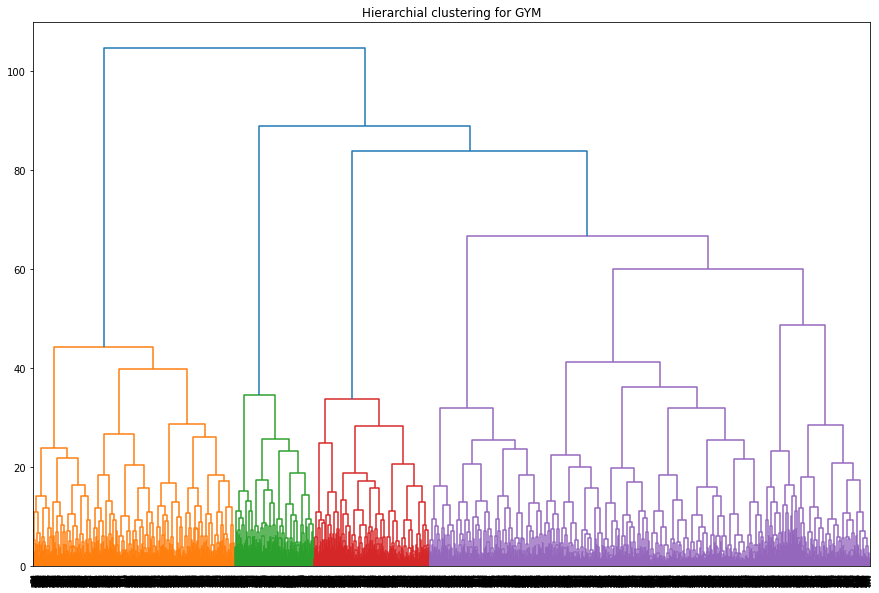

In [37]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() 
# обучаем нормализатор и преобразуем набор данных
x_sc = scaler.fit_transform(data.drop(columns = ['churn']))

#создаем таблицу «связок» между объектами
linked = linkage(x_sc, method = 'ward')

# на основе таблицы строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

На основании графика кажется оптимальным выделить 5 или 6 кластеров. Примем за число кластеров n=5.  

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [38]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = data.groupby(['cluster_km']).mean()
print(clusters)


            gender  near_location  partner  promo_friends  phone  \
cluster_km                                                         
0             0.50           0.96     0.78           0.57   1.00   
1             0.52           0.86     0.47           0.31   0.00   
2             0.50           0.00     0.46           0.08   1.00   
3             0.49           1.00     0.35           0.24   1.00   
4             0.56           0.98     0.36           0.23   1.00   

            contract_period  group_visits   age  avg_additional_charges_total  \
cluster_km                                                                      
0                     10.89          0.54 29.98                        160.76   
1                      4.79          0.43 29.30                        143.96   
2                      2.35          0.22 28.48                        135.46   
3                      1.95          0.34 28.17                        131.62   
4                      2.67          

По средним значениям признаков по кластеру можно предположить, что кластеризация прошла по признакам:

    партнерская программа
    акция "приведи друга"
    посещение групп
    длительность абонемента
    количество месяцев до окончания контракта
    средняя частота посещений в неделю
    средняя частота посещений за предыдущий месяц
    
Построим распределения признаков для кластеров.

In [41]:
claster0 = data.query('cluster_km == 0').drop('cluster_km', axis=1)
claster1 = data.query('cluster_km == 1').drop('cluster_km', axis=1)
claster2 = data.query('cluster_km == 2').drop('cluster_km', axis=1)
claster3 = data.query('cluster_km == 3').drop('cluster_km', axis=1)
claster4 = data.query('cluster_km == 4').drop('cluster_km', axis=1)

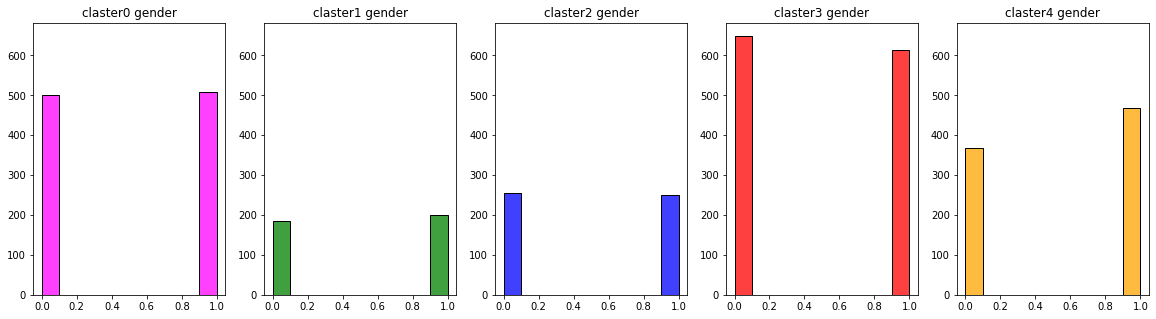

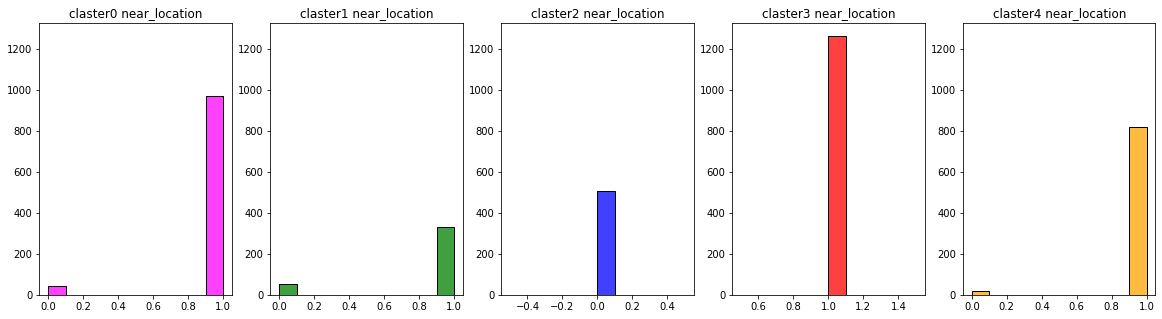

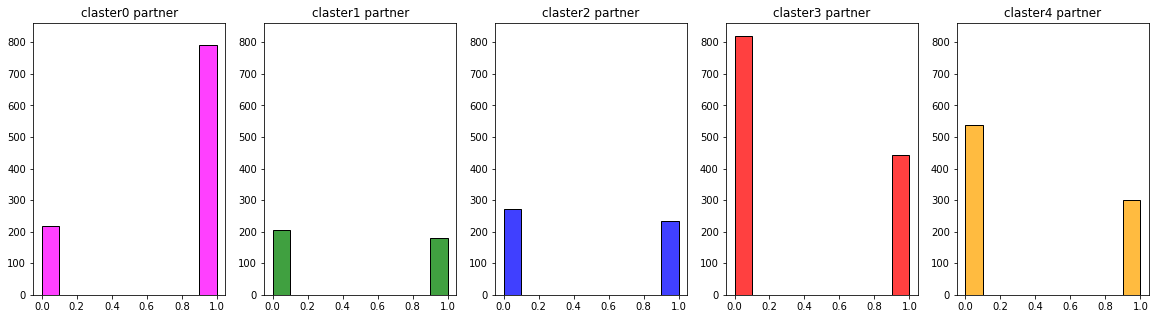

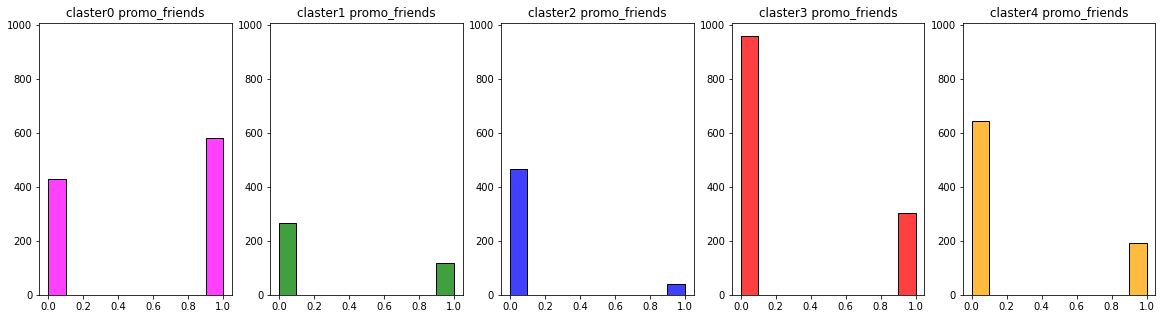

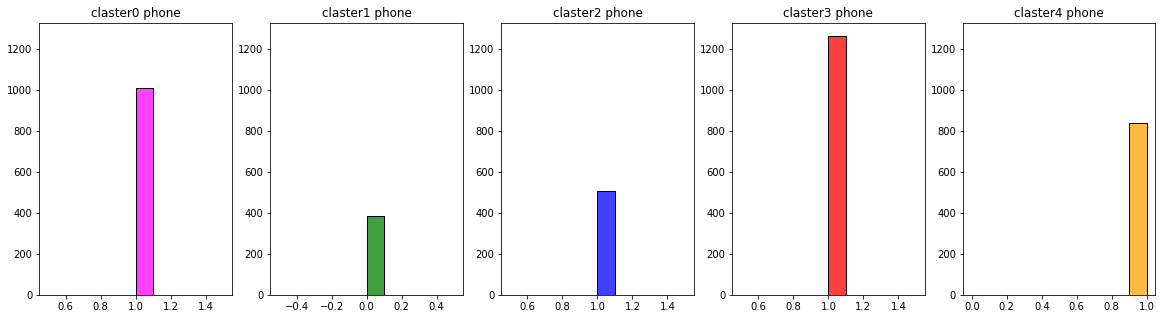

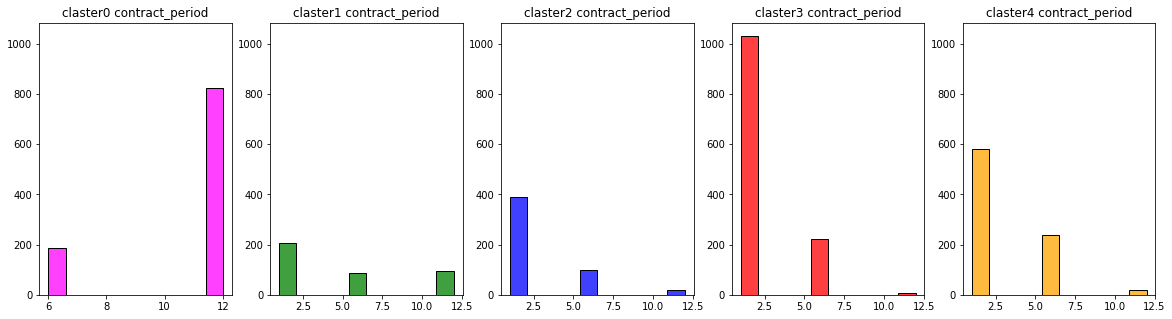

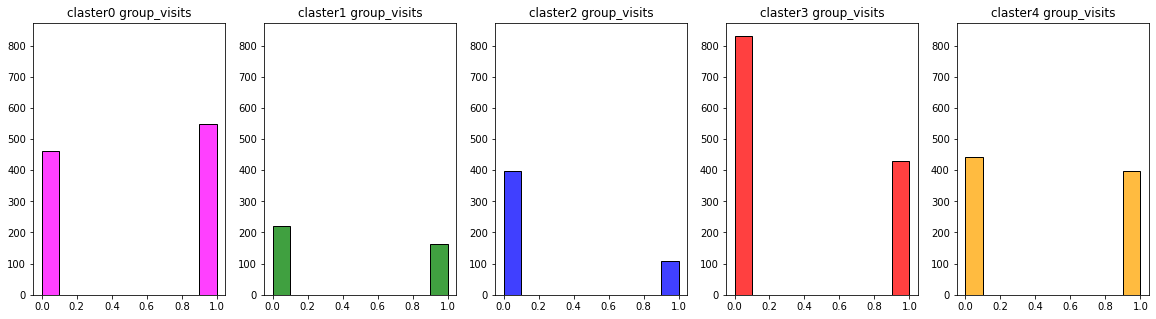

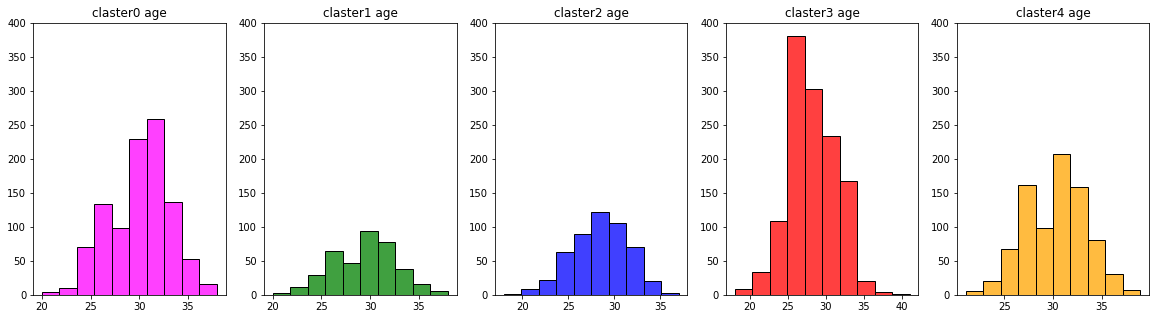

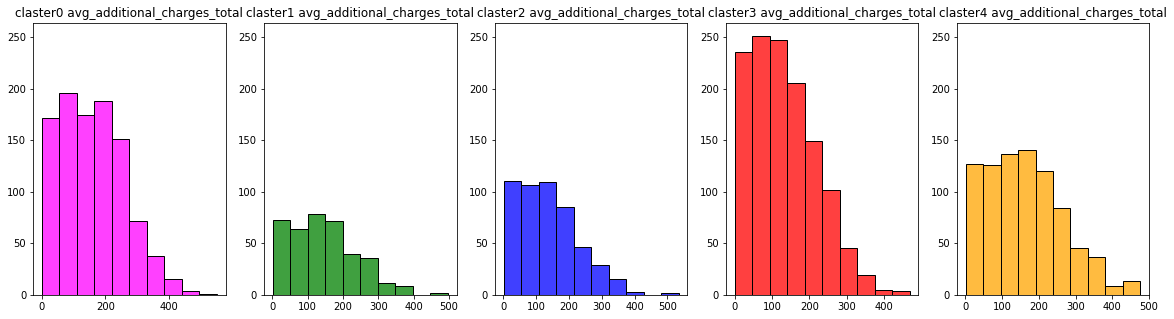

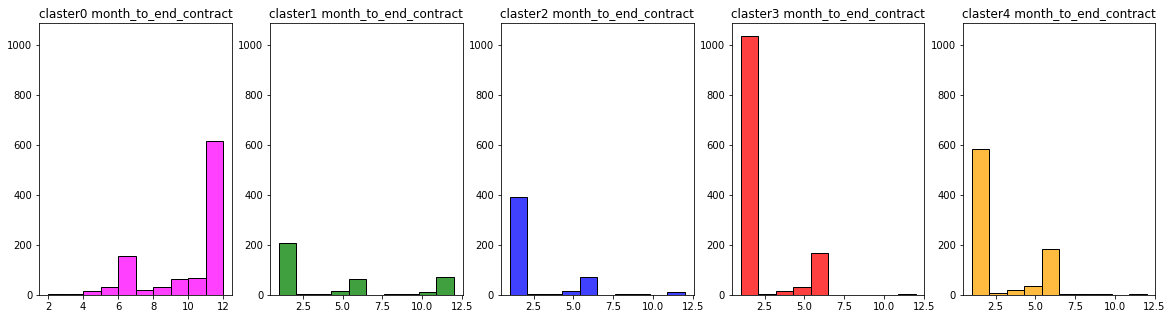

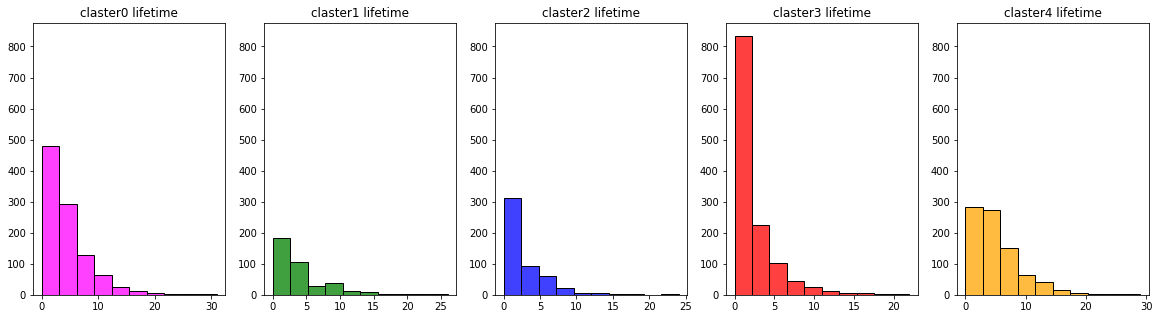

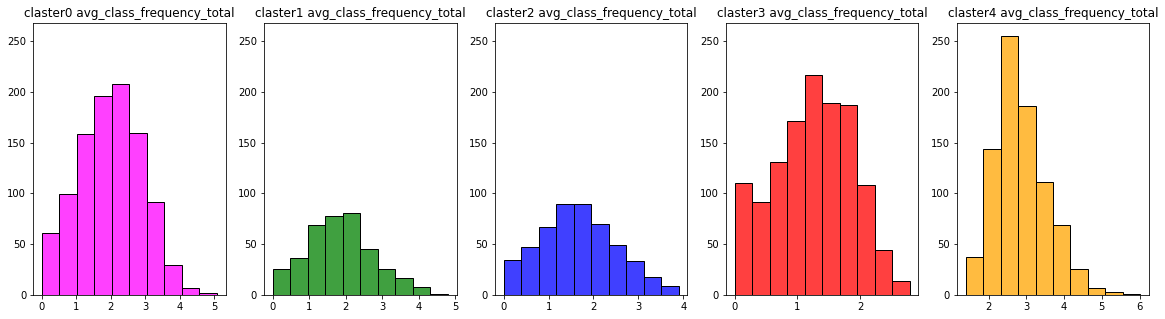

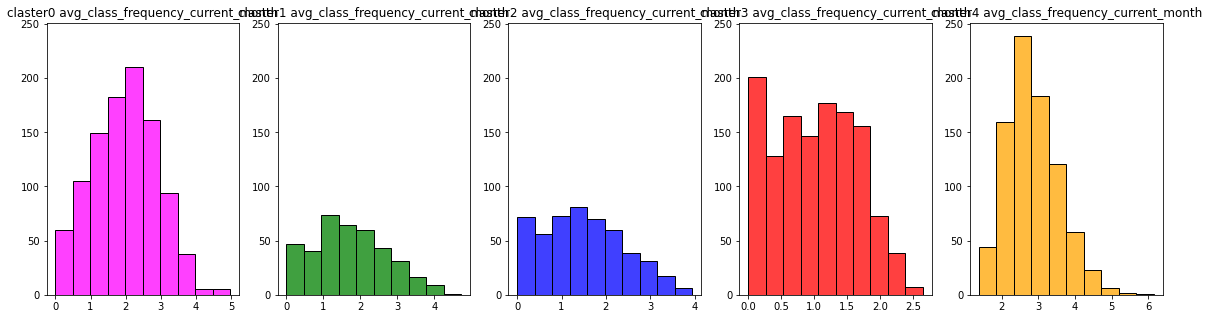

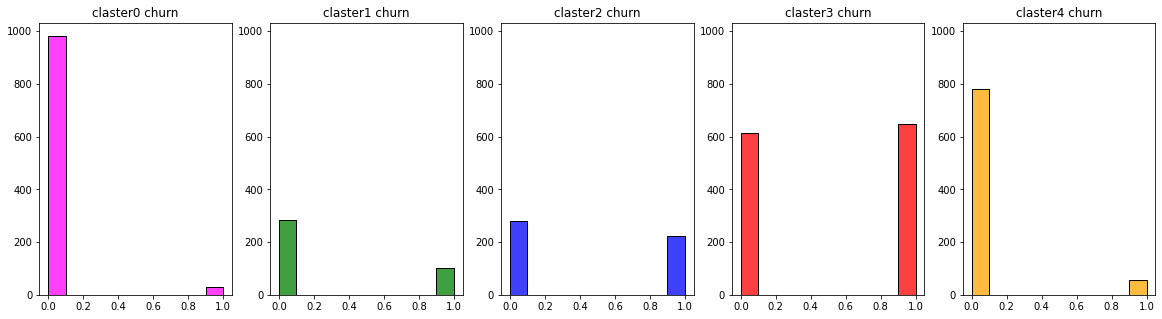

In [50]:
for feature in claster0.columns:
            
    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 5))
    
    ax1 = plt.subplot(1, 5, 1)
    sns.histplot(claster0[feature], bins=10, color = 'Magenta', ax=ax1)
    plt.title('claster0 {}'. format(feature))
    plt.xlabel('')
    plt.ylabel('')

    ax2 = plt.subplot(1, 5, 2, sharey = ax1)
    sns.histplot(claster1[feature], bins=10, color = 'Green', ax=ax2)
    plt.title('claster1 {}'.format(feature))
    plt.xlabel('')
    plt.ylabel('')
    
    ax3 = plt.subplot(1, 5, 3, sharey = ax2)
    sns.histplot(claster2[feature], bins=10, color = 'Blue', ax=ax3)
    plt.title('claster2 {}'.format(feature))
    plt.xlabel('')
    plt.ylabel('')
    
    ax4 = plt.subplot(1, 5, 4, sharey = ax3)
    sns.histplot(claster3[feature], bins=10, color = 'Red', ax=ax4)
    plt.title('claster3 {}'.format(feature))
    plt.xlabel('')
    plt.ylabel('')
    
    ax5 = plt.subplot(1, 5, 5, sharey = ax4)
    sns.histplot(claster4[feature], bins=10, color = 'Orange', ax=ax5)
    plt.title('claster4 {}'.format(feature))
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

Выделим основные признаки, наиболее сильно влияющие на отток. Это те признаки, по которым произошла кластеризация - где кластеры пересекаются минимально.

    партнерская программа - количество месяцев до окончания контракта
    акция "приведи друга" - количество месяцев до окончания контракта
    длительность абонемента - средняя частота посещений в неделю за все время с начала действия абонемента
    длительность абонемента - средняя частота посещений в неделю за месяц
    возраст - средняя частота посещений в неделю за все время с начала действия абонемента
    возраст - средняя частота посещений в неделю за месяц
    количество месяцев до окончания контракта - средняя частота посещений в неделю за все время с начала действия абонемента
    количество месяцев до окончания контракта - средняя частота посещений в неделю за месяц
    средняя частота посещений в неделю за все время с начала действия - средняя частота посещений в неделю за месяц

Похоже, что группа 1 сформирована по признаку отсутствия номера телефона.

Для каждого полученного кластера посчитаем долю оттока.

In [44]:
data.groupby(['cluster_km'])['churn'].sum() / data.groupby(['cluster_km'])['churn'].count()

cluster_km
0   0.03
1   0.27
2   0.44
3   0.51
4   0.07
Name: churn, dtype: float64

Кластеры отличаются по доле оттока. Склонны к оттоку кластеры 2 и 3, отток из них составляет 44% и 51% соответственно. Надёжны кластеры 0 и 4 - их отток 3% и 7%. Отток из кластера 1 составляет 27%. 

### Выводы

Мы сформировали типичные портреты клиентов: выделили несколько наиболее ярких групп и охарактеризовали их основные свойства.

Для решения этой задачи выполнили кластеризацию клиентов. Сначала определили количества кластеров с помощью матрицы расстояний и дендрограммы. Приняли за число кластеров n=5. Обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов.

Основные признаки, наиболее сильно влияющие на отток (по убыванию влияния):

    средняя частота посещений в неделю за все время с начала действия абонемента
    средняя частота посещений в неделю за предыдущий месяц
    количество месяцев до окончания абонемента
    длительность абонемента
    посещение групп
    возраст
    партнерская программа
    акция "приведи друга"
        
Полученные кластеры отличаются по доле оттока. Склонны к оттоку кластеры 2 и 3, отток из них составляет 44% и 51% соответственно. Надёжны кластеры 0 и 4 - их отток 3% и 7%. Отток из кластера 1 составляет 27%.

По полученной модели кластеризации можно разделять клиентов на кластеры и определять вероятность оттока.

## Общие выводы

В данном проекте перед нами стояла задача — провести анализ клиентских анкет и подготовить план действий по удержанию клиентов для сети фитнес-центров «Культурист-датасаентист»:

    - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    - проанализировать основные признаки, наиболее сильно влияющие на отток;
    - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.
    
Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. 

Сначала мы проверили данные на пропуски, дубликаты и аномалии и подготовили их к дальнейшему анализу.

Затем провели исследовательский анализ данных и выяснили, что:

    1. Датасет имеет достаточное качество и объем для анализа (4000 записей). Необходима стандартизация датасета. 
    
    2. Уходит приблизительно каждый четвертый клиент.
    
    3. Больше ушло в отток тех, кто живет поблизости, пришел не из компании-партнера и не по акции "приведи друга",  купил абонемент на 1-2 месяца, не посещает групповые занятия, у кого осталось 1-2 месяца до завершение абонемента.  
    
    6. Признаки не слишком сильно скоррелированны с целевой переменной. Хорошая корреляция (от 0.39 до 0.44) у признаков "период контракта", "возраст", "количество месяцев до окончания контракта", "частота посещений в неделю за предыдущий месяц", "количества месяцев с первого посещения клуба".
    
    7. Между собой признаки скоррелированы не сильно, за исключением пары "период контракта" и "количество месяцев до окончания контракта" (корреляция 0.97, тут понятная прямая зависимость) и пары "средняя частота посещений в неделю" и "средняя частота посещений за предыдущий месяц" (корреляция 0.95, видимо, более активные клиенты активны постоянно). Это нужно учесть при выборе линейных моделей обучения.
    
Далее мы построили модель бинарной классификации клиентов с целевым признаком - фактом оттока клиента в следующем месяце. Сначала разбили данные на обучающую и валидационную выборку в соотношении 80:20 с помощью случайного разбиения, затем стандартизировали их.

Обучили модель двумя способами:

    логистической регрессией,
    случайным лесом.

Для оценки работы моделей выбрали метрики:

    доля правильных ответов - аccuracy,
    точность - precision,
    полнота - recall.
    
На основании метрик показала себя лучше модель логистической регрессии - ее метрики выше, чем метрики модели случайного леса.

С помощью созданной модели можно прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента.

Затем мы сформировали типичные портреты клиентов: выделили несколько наиболее ярких групп и охарактеризовали их основные свойства.

Для решения этой задачи выполнили кластеризацию клиентов. Сначала определили количества кластеров с помощью матрицы расстояний и дендрограммы. Приняли за число кластеров n=5. Обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов.

Основные признаки, наиболее сильно влияющие на отток (по убыванию влияния):

    средняя частота посещений в неделю за все время с начала действия абонемента
    средняя частота посещений в неделю за предыдущий месяц
    количество месяцев до окончания абонемента
    длительность абонемента
    посещение групп
    возраст
    партнерская программа
    акция "приведи друга"
        
Полученные кластеры отличаются по доле оттока. Склонны к оттоку кластеры 2 и 3, отток из них составляет 44% и 51% соответственно. Надёжны кластеры 0 и 4 - их отток 3% и 7%. Отток из кластера 1 составляет 27%.

По полученной модели кластеризации можно разделять клиентов на кластеры и определять вероятность оттока.

Рекомендации по снижению оттока:

    1. Больше всего влияет на отток средняя частота посещений в неделю. Чтобы увеличить этот показатель, можно провести анкетирование среди клиентов, узнать о наиболее популярных группах и времени занятий, потом подвигать расписание, включив в удобное время все самое популярное.
    2. Длительность абонемента также сильно влияет на отток. Можно предлагать скидки на абонементы с дилтельностью больше месяца. Например, скидку можно заработать, выполняя специальные задания в зале (к примеру, максимальное количество отжиманий деленное на 10).
    3. Предложить специальную акцию для людей до 29 лет. Сделать упор на трендовость и крутость регулярных занятий спортом. 
    4. Развивать партнерскую программу и акцию "приведи друга". Возможно, пересмотреть условия, чтобы увеличить приток новых клиентов.